# Notebook de test

Notebook de Mickael MELKOWSKI

## Preprocessing des data

### Conversion en 256*256 et masking

In [1]:
# import
import cv2
import os
import pathlib

In [22]:
# config
data_folder_path = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/raw/COVID-19_Radiography_Dataset")
output_path = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny")
folder_to_process = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# Setting to output a smaller dataset of tiny_size number of images
make_tiny = True
tiny_size = 100

for img_type in  folder_to_process:
    print(f"Processing folder: {img_type}")

    img_folder_path = data_folder_path / img_type / "images"
    mask_folder_path = data_folder_path / img_type / "masks"

    output_folder_path = output_path / img_type
    output_folder_path.mkdir(parents=True, exist_ok=True)

    nb_image_done = 0
    for image_name, mask_name in zip(os.listdir(img_folder_path), 
                                     os.listdir(mask_folder_path)):

        image_path = img_folder_path / image_name
        mask_path = mask_folder_path / mask_name

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # resized to mask size
        image = cv2.resize(image, dsize = (256, 256)) # fixed size to mask size

        # masking
        res =  cv2.bitwise_and(image, image, mask=mask)

        # Write masked image
        output_image_name = image_name + '_masked.png'
        cv2.imwrite(output_folder_path / output_image_name, res)

        nb_image_done += 1
        if make_tiny and nb_image_done >= tiny_size:
            break

    print(f"Processing folder: {img_type} done.")

Processing folder: Lung_Opacity
Processing folder: Lung_Opacity done.
Processing folder: COVID
Processing folder: COVID done.
Processing folder: Normal
Processing folder: Normal done.
Processing folder: Viral_Pneumonia
Processing folder: Viral_Pneumonia done.


## Premiers models

In [36]:
# import
import pathlib

import numpy as np

import tensorflow as tf
import tensorrt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
data_dir = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny")
img_height, img_width = 256, 256
batch_size = 32

In [21]:
# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode= "grayscale",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 400 files belonging to 4 classes.


Using 320 files for training.


In [22]:
# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode= "grayscale",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [35]:
# Transform keras dataset to numpy ndarray
# from https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
# For train data
all_images = []
all_labels = []

for images, labels in train_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_train = np.concatenate(all_images)
y_train = np.concatenate(all_labels)

# For test data
all_images = []
all_labels = []

for images, labels in val_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images)
y_test = np.concatenate(all_labels)


In [48]:
# normalization
X_train = X_train / 255
X_test = X_test / 255

# encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Test sur archi LeNet

### Definition du modele

In [50]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")
conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
flatten = Flatten()
dropout = Dropout(rate = 0.2)
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = 4,
                activation = 'softmax')

x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)
x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

lenet = Model(inputs = inputs, outputs = outputs)

/home/tylio/code/radio_pulmo_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilation et fitting

In [51]:
# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

# Entraînement_1
nb_epochs = 16
nb_batch_size = 200

training_history_lenet = lenet.fit(X_train, y_train,           # données
                                   validation_split = 0.2,     # split de test
                                   epochs = nb_epochs,         # nombre d'epochs
                                   batch_size = nb_batch_size) # taille des batchs

# extraire les précisions sur les bases d'entraînement et de test obtenues pendant l'entraînement
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

Epoch 1/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.2448 - loss: 1.3864 - val_accuracy: 0.2656 - val_loss: 1.3865
Epoch 2/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.2483 - loss: 1.3863 - val_accuracy: 0.2344 - val_loss: 1.3870
Epoch 3/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.2561 - loss: 1.3862 - val_accuracy: 0.2344 - val_loss: 1.3879
Epoch 4/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.2711 - loss: 1.3859 - val_accuracy: 0.2344 - val_loss: 1.3884
Epoch 5/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.2645 - loss: 1.3852 - val_accuracy: 0.2344 - val_loss: 1.3872
Epoch 6/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.2645 - loss: 1.3856 - val_accuracy: 0.2344 - val_loss: 1.3869
Epoch 7/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.2578 - loss: 1.3860 - val_accuracy: 0.2344 - val_loss: 1.3869
Epoch 8/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.2628 - loss: 1.3858 - val_accuracy: 0.2344 - val_loss:

### Plot

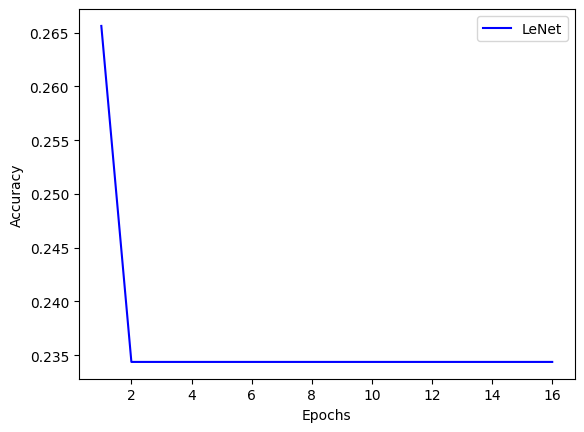

In [52]:
# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_lenet, 
         label = 'LeNet',
         color = 'blue')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

## Test load direct

In [62]:
# import
import cv2
import os
import pathlib


import numpy as np

import tensorflow as tf
import tensorrt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from keras.utils import to_categorical



In [80]:
# test sans passer par la recup à la main
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  # Automatically infer labels from subdirectories
    label_mode="categorical",  # For multi-class classification
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to a standard size
    batch_size=32,  # Set the batch size
    color_mode= "grayscale",
    shuffle=True  # Shuffle the dataset for better training
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  # Automatically infer labels from subdirectories
    label_mode="categorical",  # For multi-class classification
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to a standard size
    batch_size=32,  # Set the batch size
    color_mode= "grayscale",
    shuffle=True  # Shuffle the dataset for better training
)

# model definition
num_classes = 4

model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    Normalization(axis=-1),  # Normalizes along the last axis (features), per batch ?
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes --> 4
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# model.summary()
nb_epochs = 6 # 6 were found to maximize results
model_history = model.fit(train_dataset, epochs=nb_epochs)  # Adjust the number of epochs as needed

Found 400 files belonging to 4 classes.
Using 320 files for training.


Found 400 files belonging to 4 classes.
Using 80 files for validation.
Epoch 1/6


/home/tylio/code/radio_pulmo_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.2548 - loss: 377.5478
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.5097 - loss: 15.4107
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.7642 - loss: 1.0177
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.9341 - loss: 0.2278
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.9906 - loss: 0.0512
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.9957 - loss: 0.0359


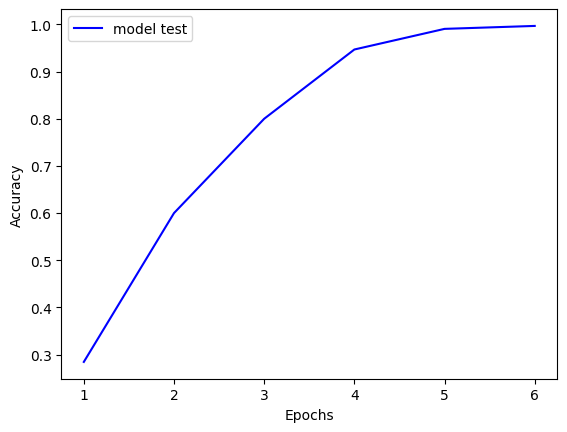

In [81]:
# Courbe du score de test du réseau test
train_acc_model = model_history.history['accuracy']
val_acc_model = model_history.history['accuracy']

plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_model, 
         label = 'model test',
         color = 'blue')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

### Prediction model test

In [75]:
# import 
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# Make Predictions on the Dataset
# Get the true labels and predictions
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert categorical labels to integer
    pred_labels.extend(np.argmax(preds, axis=1))  # Convert softmax output to predicted class


['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [83]:
# Confusion matrix
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Optionally normalize the confusion matrix (if you want percentage instead of raw counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

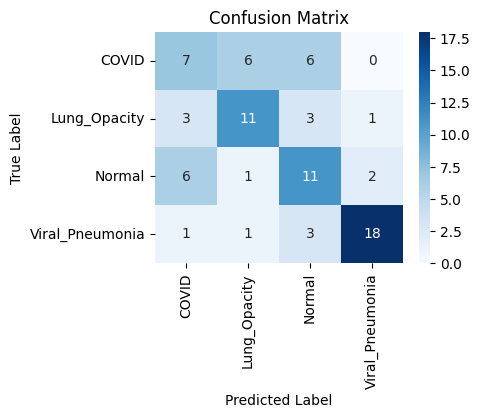

In [89]:
# Visualization 
# get real label names
class_names = test_dataset.class_names

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()